In [1]:
from __future__ import division, print_function, absolute_import

import json
import numpy as np
import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

Instructions for updating:
Use the retry module or similar alternatives.
hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)


In [2]:
# Load planesnet data
f = open('../../planesnet.json')
planesnet = json.load(f)
f.close()

# Preprocess image data and labels
X = np.array(planesnet['data']) / 255.
X = X.reshape([-1,3,20,20]).transpose([0,2,3,1])
Y = np.array(planesnet['labels'])
Y = to_categorical(Y, 2)

In [3]:
# Real-time data preprocessing
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

# Real-time data augmentation
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)

In [4]:
# Convolutional network building
network = input_data(shape=[None, 20, 20, 3],
                     data_preprocessing=img_prep,
                     data_augmentation=img_aug)
conv1 = conv_2d(network, 32, 3, activation='relu')
pool1 = max_pool_2d(conv1, 2)
conv2 = conv_2d(pool1, 64, 3, activation='relu')
conv3 = conv_2d(conv2, 64, 3, activation='relu')
pool2 = max_pool_2d(conv3, 2)
fc1 = fully_connected(pool2, 512, activation='relu')
dp1 = dropout(fc1, 0.5)
fc2 = fully_connected(dp1, 2, activation='softmax')
network = regression(fc2, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.001)
model = tflearn.DNN(network, tensorboard_verbose=0)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
model.load('./models/tf_model')

INFO:tensorflow:Restoring parameters from /Users/guolinliu/projects/python/3.6/planesnet/ml/NN/models/tf_model


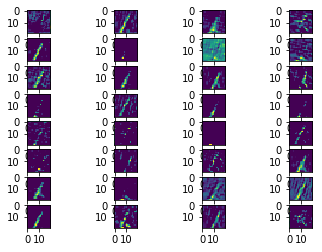

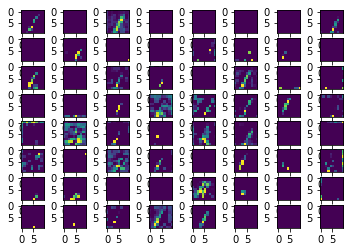

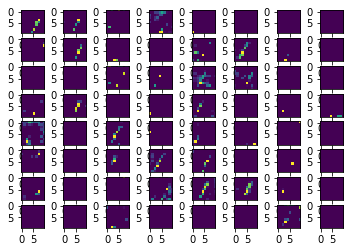

Actual Class: 0
Predicted Class: 0


In [29]:
import random
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

m_conv1 = tflearn.DNN(conv1, session=model.session)
m_conv2 = tflearn.DNN(conv2, session=model.session)
m_conv3 = tflearn.DNN(conv3, session=model.session)

for i in range(1):
    # Choose a random image and its label
    rand_int = random.randrange(0,len(planesnet['data']))
    img = np.array(planesnet['data'][rand_int]) / 255.
    img = img.reshape((3, 400)).T.reshape((20,20,3))
    label = planesnet['labels'][rand_int]
    
    # Display the image
#     plt.imshow(img)
#     plt.show()
    
    # Predict the image class
    prediction = model.predict_label([img])[0][0]
    
#     fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    
    o_conv1 = m_conv1.predict([img])
    for i in range(32):
        plt.subplot(8,4,i+1)
        plt.imshow(o_conv1[0][:,:,i])
    plt.show()
    
    o_conv2 = m_conv2.predict([img])
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.imshow(o_conv2[0][:,:,i])
    plt.show()
    
    o_conv3 = m_conv3.predict([img])
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.imshow(o_conv3[0][:,:,i])
    plt.show()
    
    # Output acutal and predicted class - 0 = 'no-plane', 1 = 'plane'
    print('Actual Class: ' + str(label))
    print('Predicted Class: ' + str(prediction))